In [33]:
import numpy as np
import msicpe.san as san
from plotly import express as px
import scipy.signal as signal
import matplotlib.pyplot as plt

DOSSIER_DONNEES = "apprentissage"

# ============================================
#  SIGNAL À CLASSIFIER : SIGNAL_4
#  Domaine temporel + domaine fréquentiel
# ============================================

# Chemin du fichier signal_4
chemin_signal4 = f"{DOSSIER_DONNEES}/signal_4.npz"

# Chargement des données
donnees4 = np.load(chemin_signal4)
t4 = donnees4["t"]
s4 = donnees4["s"]

# Fréquence d'échantillonnage
fe4 = 1.0 / (t4[1] - t4[0])

# Centrage du signal
s4_centre = s4 - np.mean(s4)

# ----- Domaine temporel -----
fig_t = px.line(
    x=t4,
    y=s4_centre,
    labels={"x": "Temps (s)", "y": "Amplitude"},
    title="Signal 4 – domaine temporel (signal centré)"
)
fig_t.show()

# ----- Domaine fréquentiel -----
N4 = len(s4_centre)
frequences4 = np.fft.rfftfreq(N4, d=1.0 / fe4)
spectre_complexe4 = np.fft.rfft(s4_centre)
amplitude4 = np.abs(spectre_complexe4)

# Normalisation
amplitude4_norm = amplitude4 / np.max(amplitude4)

fig_f = px.line(
    x=frequences4,
    y=amplitude4_norm,
    labels={"x": "Fréquence (Hz)", "y": "Amplitude normalisée"},
    title="Signal 4 – spectre d'amplitude normalisé"
)
fig_f.show()
eps = 1e-12  # éviter log(0)
spectre_log = 20 * np.log10(amplitude4 + eps)

fig_log = px.line(
    x=frequences4,
    y=spectre_log,
    labels={"x": "Fréquence (Hz)", "y": "Amplitude (dB)"},
    title="Signal 4 – spectre en échelle logarithmique (dB)"
)
fig_log.show()

In [34]:




# ============================
#  SPECTRES DES VOYELLES
# ============================

voyelles = ["a", "e", "i", "o", "u"]

for v in voyelles:
    chemin_fichier = f"{DOSSIER_DONNEES}/{v}_1.npz"

    donnees = np.load(chemin_fichier)
    t = donnees["t"]
    s = donnees["s"]

    # Fréquence d'échantillonnage
    fe = 1.0 / (t[1] - t[0])

    # Centrage du signal
    s_centre = s - np.mean(s)

    # FFT
    N = len(s_centre)
    spectre_complexe = np.fft.rfft(s_centre)
    frequences = np.fft.rfftfreq(N, d=1.0 / fe)
    amplitude = np.abs(spectre_complexe)

    # Normalisation
    amplitude_norm = amplitude / np.max(amplitude)

    # Tracé
    fig = px.line(
        x=frequences,
        y=amplitude_norm,
        labels={"x": "Fréquence (Hz)", "y": "Amplitude normalisée"},
        title="Spectre de la voyelle " + v
    )
    fig.show()

In [35]:

VOYELLES = ["a", "e", "i", "o", "u"]
H = 10  # fondamentale + H harmoniques -> vecteur de taille H+1


# ======================================================
# 1) Fonctions utilitaires
# ======================================================

def enlever_DC(s):
    """Enlève la composante continue du signal."""
    return s - np.mean(s)


def spectre_brut(s, t):
    """Retourne (nu, |TF(s)|)."""
    nu, tf_s = san.trans_fourier(s, t)  # même ordre que dans le sujet
    return nu, np.abs(tf_s)


def normaliser_spectre(tf_abs):
    """Normalise un spectre pour que son max vaille 1."""
    return tf_abs / np.max(tf_abs)


def vecteur_caracteristique(son_npz, H):
    """
    Calcule le vecteur de caractéristiques (en dB) :
    [fondamentale, 2ème harmonique, ..., (H+1)-ème harmonique]
    pour un seul fichier .npz contenant 's' et 't'.
    """
    s = enlever_DC(son_npz["s"])
    t = son_npz["t"]

    # spectre brut
    nu, tf_abs = spectre_brut(s, t)

    # spectre normalisé
    tf_norm = normaliser_spectre(tf_abs)

    # fondamentale détectée sur le spectre normalisé
    f0 = san.detect_fondamentale(tf_norm, nu)

    # liste des fréquences utiles : f0, 2f0, ..., (H+1)f0
    freq_utiles = [k * f0 for k in range(1, H + 2)]

    # détection des pics à ces fréquences
    freq_pics, amp_pics = san.detect_pics(tf_norm, freq_utiles, nu)

    # passage en dB (log base 10)
    vect_dB = 20 * np.log10(amp_pics)

    return vect_dB  # taille H+1


def vecteur_moyen(liste_sons, H):
    """
    Moyenne des vecteurs de caractéristiques (en dB)
    pour une liste de sons (par ex. a_1,...,a_5).
    """
    vecteurs = []
    for son in liste_sons:
        vecteurs.append(vecteur_caracteristique(son, H))
    return np.mean(vecteurs, axis=0)


def distance_euclidienne(v1, v2):
    """Distance euclidienne entre deux vecteurs NumPy."""
    diff = v1 - v2
    return np.sqrt(np.sum(diff**2))


def distance_normalisee(v1, v2):
    d = distance_euclidienne(v1, v2)
    n = len(v1)
    d_max = np.sqrt(n)
    return d / d_max  # valeur entre 0 et 1


# ======================================================
# 2) Phase d'apprentissage : vecteurs moyens des voyelles
# ======================================================

# listes de sons par voyelle
sons_a = [np.load(f"{DOSSIER_DONNEES}/a_{k}.npz") for k in range(1, 6)]
sons_e = [np.load(f"{DOSSIER_DONNEES}/e_{k}.npz") for k in range(1, 6)]
sons_i = [np.load(f"{DOSSIER_DONNEES}/i_{k}.npz") for k in range(1, 6)]
sons_o = [np.load(f"{DOSSIER_DONNEES}/o_{k}.npz") for k in range(1, 6)]
sons_u = [np.load(f"{DOSSIER_DONNEES}/u_{k}.npz") for k in range(1, 6)]

# vecteurs moyens en dB
vect_a_dB = vecteur_moyen(sons_a, H)
vect_e_dB = vecteur_moyen(sons_e, H)
vect_i_dB = vecteur_moyen(sons_i, H)
vect_o_dB = vecteur_moyen(sons_o, H)
vect_u_dB = vecteur_moyen(sons_u, H)



# pour la classification, on garde ces vecteurs en dB :
liste_vecteurs_voyelles_dB = [vect_a_dB, vect_e_dB, vect_i_dB, vect_o_dB, vect_u_dB]
noms_voyelles = ["a", "e", "i", "o", "u"]

# mais on prépare aussi la version en amplitude pour affichage :
vect_a_amp = 10 ** (vect_a_dB / 20)
vect_e_amp = 10 ** (vect_e_dB / 20)
vect_i_amp = 10 ** (vect_i_dB / 20)
vect_o_amp = 10 ** (vect_o_dB / 20)
vect_u_amp = 10 ** (vect_u_dB / 20)

print("\nVecteurs moyens (en amplitude normalisée) :")
print("a :", vect_a_amp)
print("e :", vect_e_amp)
print("i :", vect_i_amp)
print("o :", vect_o_amp)
print("u :", vect_u_amp)


# ======================================================
# 3) Signal à classer : signal_4
# ======================================================

son4 = np.load(f"{DOSSIER_DONNEES}/signal_4.npz")
# calcul du vecteur de caractéristiques en dB
vect_4_dB = vecteur_caracteristique(son4, H)
# même vecteur en amplitude (pour comparaison avec un spectre normalisé)
vect_4_amp = 10 ** (vect_4_dB / 20)
print("Vecteur du signal_4 (en amplitude) :", vect_4_amp)


# ======================================================
# 4) Classification par distance euclidienne (dans l’espace dB)
# ======================================================

distances = []
for vect_voyelle_dB in liste_vecteurs_voyelles_dB:
    distance = distance_normalisee(vect_4_dB, vect_voyelle_dB)
    distances.append(distance)

print("\nDistances euclidiennes NORMALISÉES (en dB) :")
for i in range(len(noms_voyelles)):
    nom = noms_voyelles[i]
    distance = distances[i]
    print(f"{nom} : {distance}")

# indice de la distance minimale
indice_min = int(np.argmin(distances))
voyelle_predite = noms_voyelles[indice_min]

print(f"\n>>> Le signal_4 est classé comme la voyelle : '{voyelle_predite}'")


Vecteurs moyens (en amplitude normalisée) :
a : [0.95748216 0.7411095  0.19371144 0.31157362 0.26042646 0.4755126
 0.3252645  0.2744932  0.18800053 0.12962516 0.24229461]
e : [0.8302869  0.8281027  0.29483214 0.5563778  0.09621964 0.04686229
 0.03910685 0.03600792 0.02020668 0.03260075 0.03191609]
i : [9.1892660e-01 7.0385599e-01 7.6681778e-02 1.4298869e-02 4.2590853e-03
 3.8348897e-03 2.2514351e-03 1.1680861e-03 9.9694461e-04 6.7738985e-04
 8.0331700e-04]
o : [0.57795346 0.8824591  0.8170247  0.22509086 0.05028335 0.05633428
 0.01112892 0.00426056 0.00237915 0.00175873 0.00149583]
u : [0.9928677  0.629181   0.06507329 0.01354329 0.00718748 0.0037559
 0.00159031 0.00129924 0.00142461 0.00137572 0.00289311]
Vecteur du signal_4 (en amplitude) : [1.         0.7911299  0.3195807  0.4099461  0.56778747 0.6023391
 0.27079907 0.21775368 0.2057651  0.2639734  0.125112  ]

Distances euclidiennes NORMALISÉES (en dB) :
a : 3.7345665744800924
e : 13.960937719973492
i : 37.274804643924725
o : 26.6

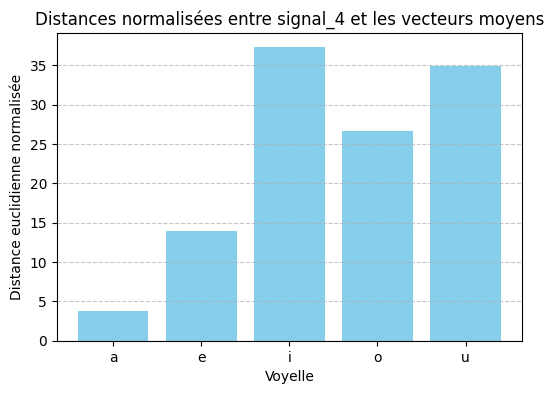

In [ ]:
import matplotlib.pyplot as plt

# Transformer la liste en dictionnaire#
distances_dict = {nom: dist for nom, dist in zip(noms_voyelles, distances)}

# Affichage barplot
plt.figure(figsize=(6,4))
plt.bar(distances_dict.keys(), distances_dict.values(), color='skyblue')
plt.title("Distances normalisées entre signal_4 et les vecteurs moyens")
plt.xlabel("Voyelle")
plt.ylabel("Distance euclidienne normalisée")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
